# Docling 架構 (Docling Architecture)

Docling 的高階架構如下圖所示。

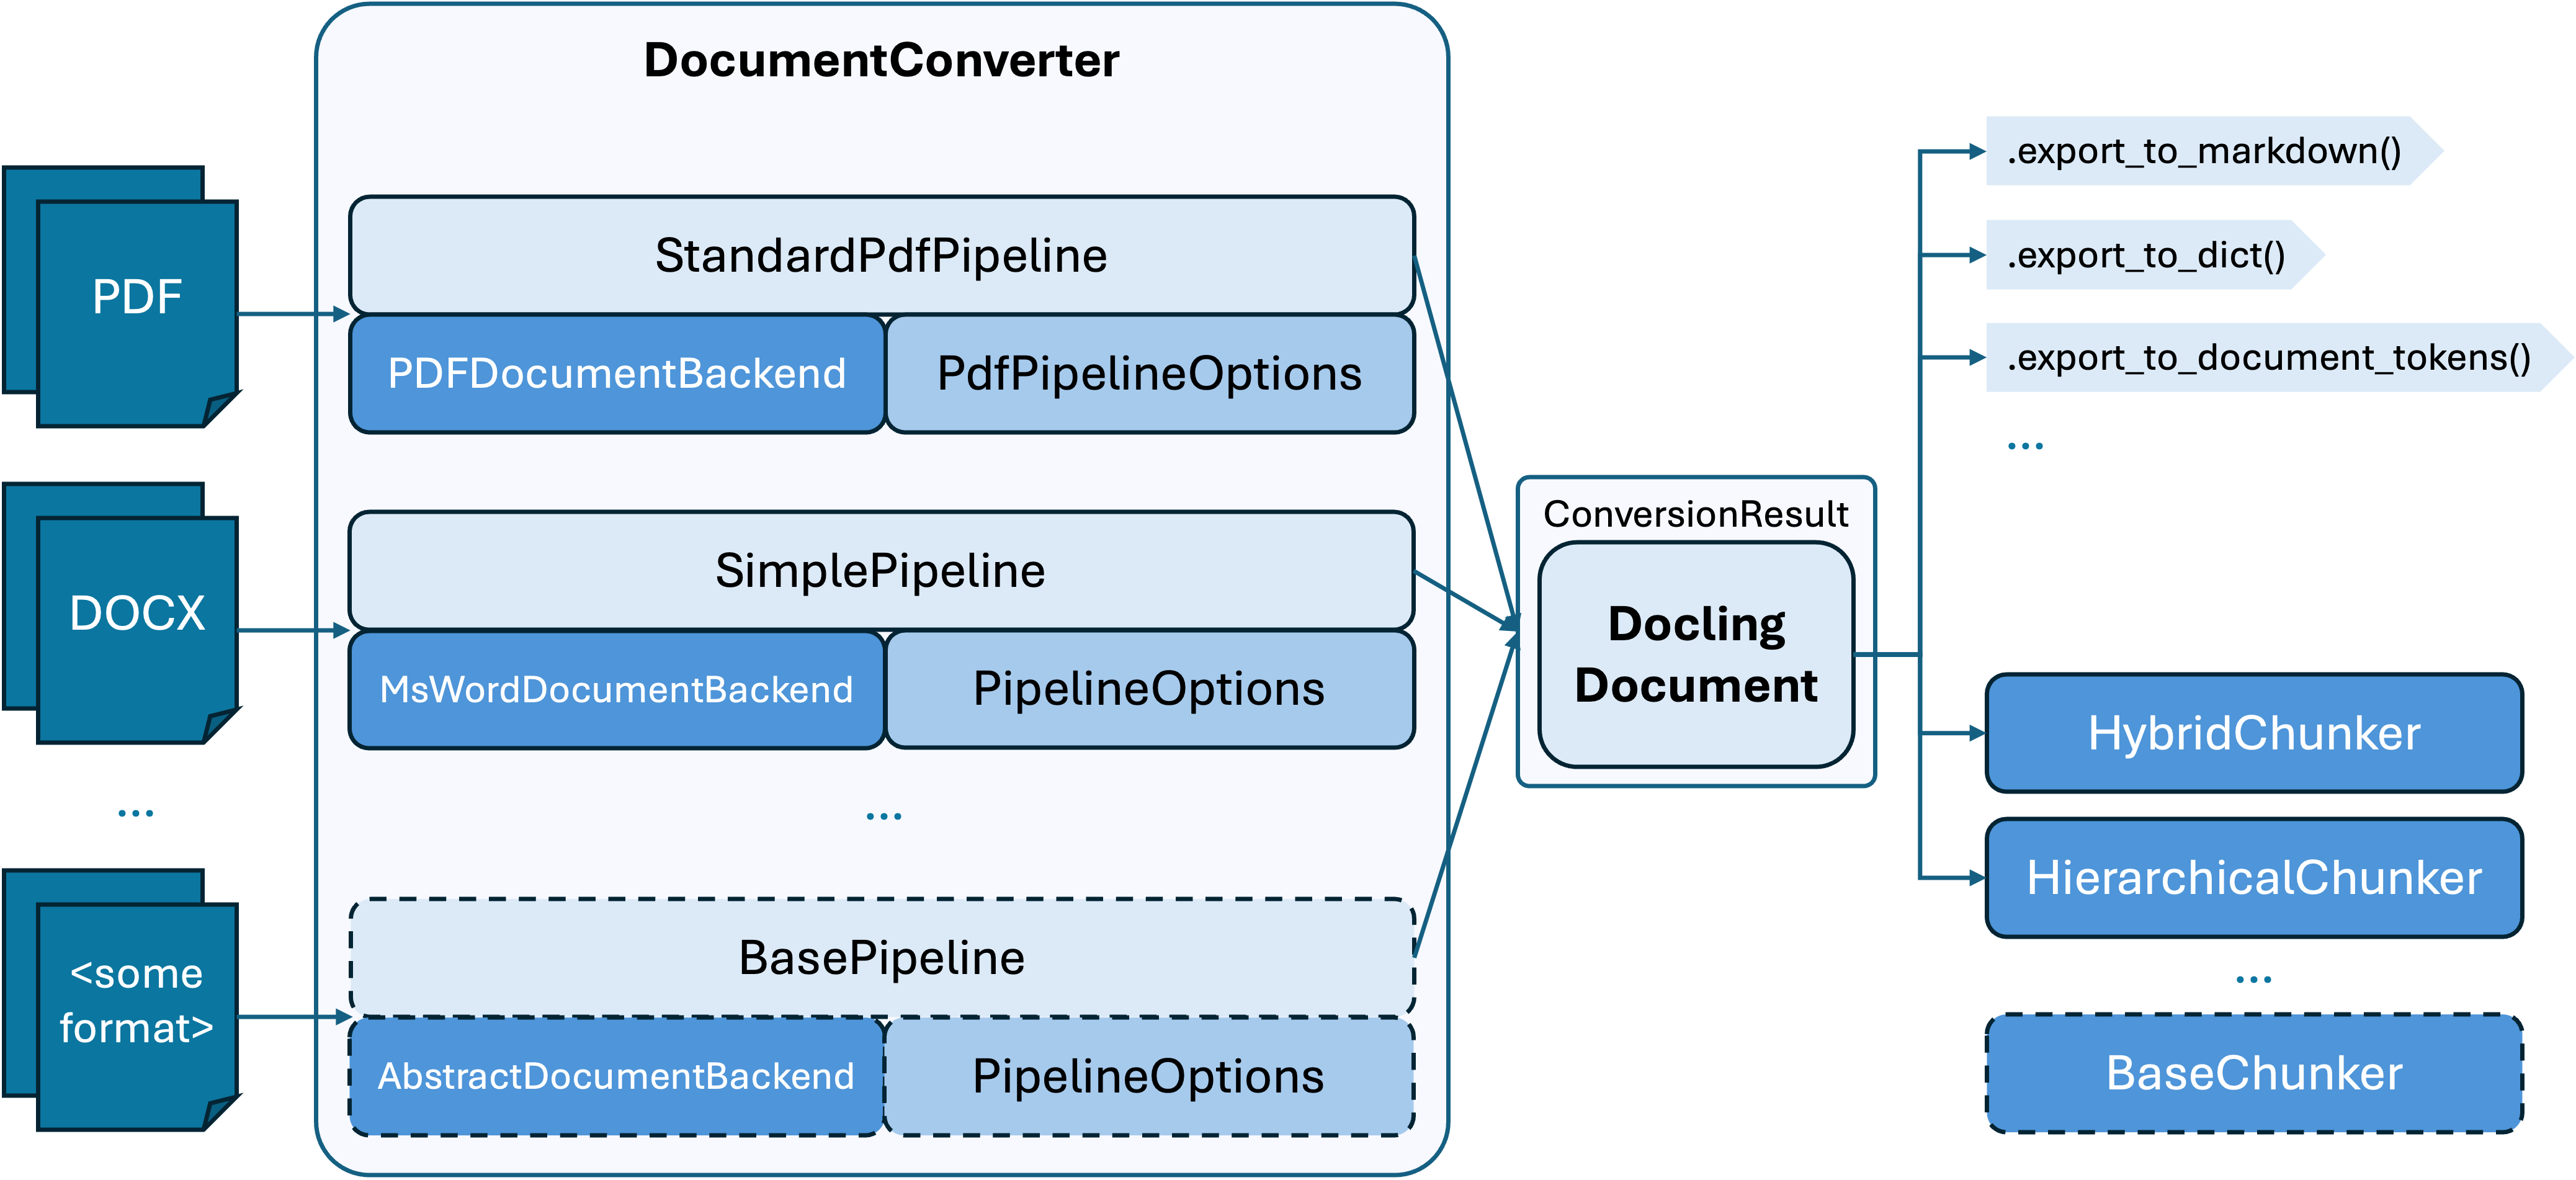 
*圖 1. Docling 架構*

Docling 採用**基於插件（plugin-based）**的架構，用於解析不同格式的文件（稱為 **converter**）並從中抽取文字。  
系統預設提供 PDF 與 MS Office 文件格式（DOCX、PPTX、XLSX）的 converter，並可使用 Python 程式碼進一步自訂。  
開發者也可以撰寫自己的 converter，繼承 Docling 提供的基礎類別以支援其他格式。

不同格式的文件在記憶體中會被解析成一個標準的 Python 物件 **`DoclingDocument`**，這是一種與格式無關的結構化文件表示（包含文字、標題、段落、清單、表格、圖片等）。  
這種記憶體內的表示可以再輸出為多種格式（例如 Markdown、JSON）。

你可以將文件透過一系列的 converter 處理，並在管線（pipeline）中進行後處理，產出適合餵入 LLM（例如用於 RAG）、微調現有模型，或從頭訓練基礎模型的輸出。

---

# 概念與術語 (Concepts and Terminology)

## 處理管線 (Processing Pipeline)

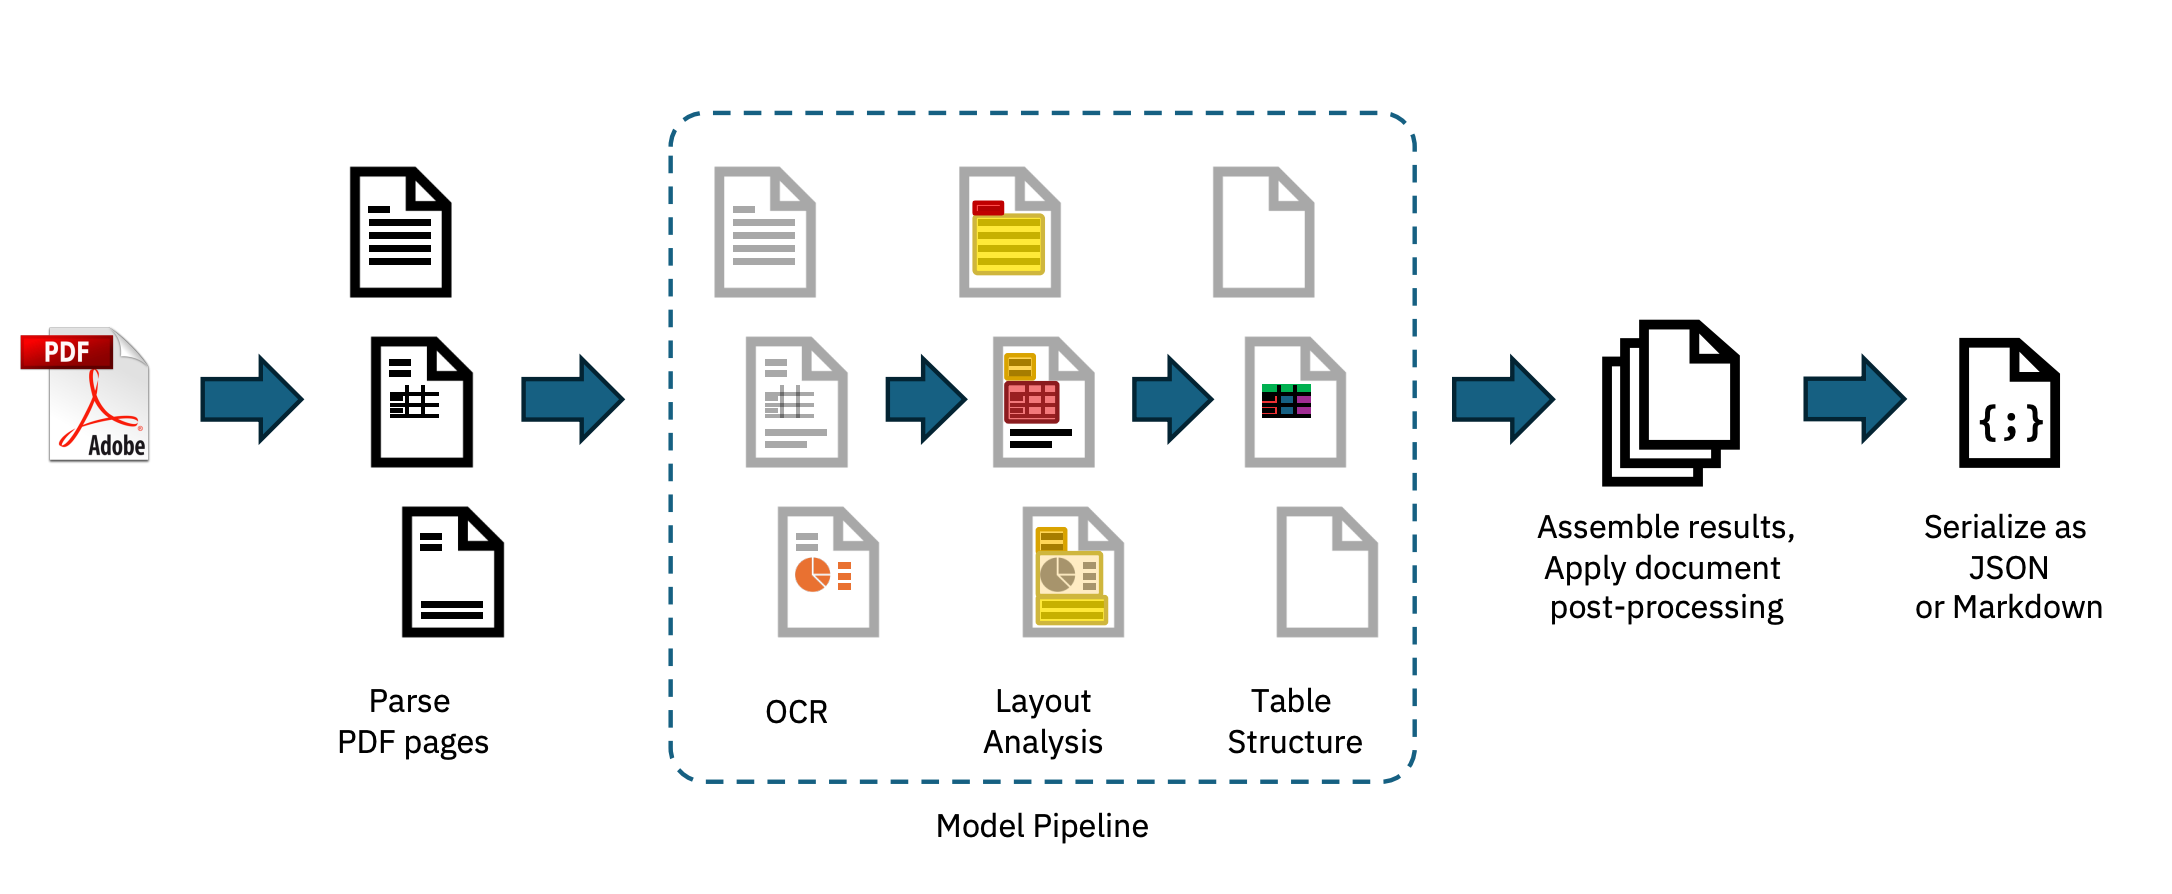
*圖 2. Docling 處理管線*

Docling 採用線性處理管線，每個文件會依序執行以下步驟：

1. **文件解析 (Parsing)**  
   由對應格式的 converter 解析文件，取得文字 token（包含字串內容與其在頁面上的座標），以支援後續操作。

2. **模型處理 (Model Pipeline)**  
   標準的模型管線會在文件的每一頁上獨立執行 AI 模型，用於抽取各種特徵和內容，例如版面結構、表格結構等。

3. **後處理 (Post-Processing)**  
   彙總所有頁面的結果，增強中繼資料、偵測文件語言、推斷閱讀順序，最終組裝成型別化的 **DoclingDocument**，可序列化為 JSON 或 Markdown。

---

## 文件解析器 (Document Parsers)

Docling 提供多種預設解析器（稱為 **backend**），用來處理不同格式的文件。  
這些 backend 能夠偵測並抽取文件中的文字與結構，供後續流程使用。

---

## DoclingDocument

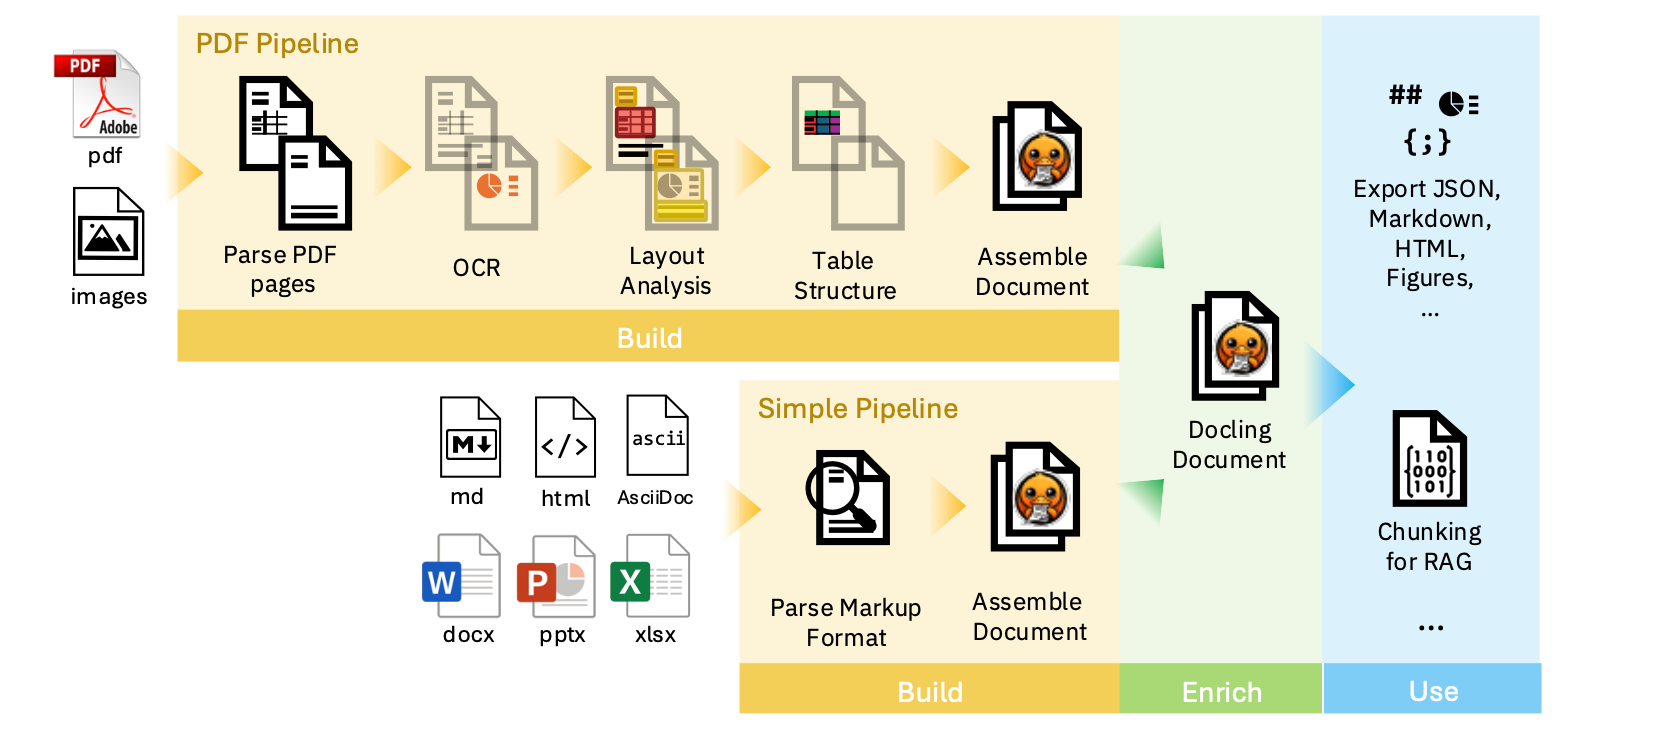 
*圖 3. Docling 建立 DoclingDocument 的流程*

從 **Docling v2** 開始，引入統一的記憶體內文件表示 **`DoclingDocument`**，其定義為 **Pydantic** 資料型別，能夠表達文件常見的特徵，例如：

- 文字、表格、圖片等多種元素  
- 文件階層（章節、段落、群組）  
- 區分正文、頁首、頁尾等不同部分  
- 版面資訊（如 bounding box）  
- 文件來源（provenance）資訊  

此外，Docling 提供一套 **流暢式 API（fluent APIs）**，可在程式中動態建立 `DoclingDocument`。

---

## 序列化 (Serialization)

**序列化器（serializer）** 是將記憶體中的複雜 `DoclingDocument` 物件轉換為標準格式（如 JSON 或 Markdown）的函式，方便儲存、傳輸與在下游應用中使用。  
Docling 內建多種序列化器，也允許使用者繼承基礎類別來自訂序列化邏輯。

---

## 分塊 (Chunking)

**Chunker** 是 Docling 提供的抽象化元件，用來將 `DoclingDocument` 拆分成多個「區塊（chunk）」，每個區塊包含部分文件內容與對應的中繼資料。

Docling 提供彈性化的 chunker 階層設計：
- 基礎型別：`BaseChunker`  
- 內建各種具體子類別（可直接使用或擴充）

與生成式 AI 框架（如 **LlamaIndex**）整合時，通常透過 `BaseChunker` 介面，讓使用者可以輕鬆接入內建、自定義或第三方實作。

> **兩種主要分塊方式：**
> 1. 將 `DoclingDocument` 先匯出為 Markdown（或類似格式），再進行使用者定義的後處理分塊。  
> 2. 直接使用 Docling 原生的 chunker 在 `DoclingDocument` 上運行，生成分塊。

---

## 插件 (Plugins)

Docling 工具包與函式庫採用模組化設計，可在管線的各個階段擴充功能。  
例如：  
- 在處理包含掃描影像的 PDF 時，可自由選擇不同的 OCR 函式庫。  
- 幾乎所有元件（backends、serializers、chunkers）都提供預設實作，並允許在程式中自訂擴展。

---